In [1]:
from scipy.sparse import csr_matrix
import implicit
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from catalyst import metrics

c:\users\май\appdata\local\programs\python\python36\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
root = '../data/parquets/'
book = pd.read_parquet(root + '/book_views.csv.parquet.gz', engine='pyarrow')

In [3]:
book = book[:1000]

In [4]:
users = book.drop_duplicates(subset = 'user_id').user_id.to_list()

In [5]:
reversed_books = book.iloc[::-1]

In [6]:
def get_test_subset(reversed_views):
    test_df = pd.DataFrame()
    for user in tqdm(users):
        user_data = reversed_views[reversed_views.user_id == user]
        if user_data.count()[0]>3:
            for i in range(3):
                test_df = test_df.append(user_data.iloc[i])
        else:
            test_df = test_df.append(user_data)
    return test_df

In [7]:
book_test = get_test_subset(reversed_books)

  0%|          | 0/115 [00:00<?, ?it/s]

In [8]:
train_df = pd.concat([reversed_books, book_test]).drop_duplicates(keep=False)

In [9]:
book_test.head()

,user_id,item_id,rate,timestamp
681,4.0,232402.0,10.0,1.364018e+09
0,4.0,234705.0,0.0,1.363316e+09
1,116482.0,234705.0,0.0,1.363334e+09
999,112934.0,96359.0,0.0,1.364402e+09
998,112934.0,28860.0,0.0,1.364402e+09


In [10]:
train_df.head()

,user_id,item_id,rate,timestamp
996,112934.0,150043.0,0.0,1.364402e+09
995,112934.0,137107.0,0.0,1.364401e+09
994,112934.0,127229.0,0.0,1.364401e+09
993,112934.0,115687.0,0.0,1.364401e+09
992,112934.0,161352.0,0.0,1.364401e+09


# Preparation

In [11]:
d = train_df.groupby('user_id').sum()['rate']
dislikers = d[d <= 0].index.to_list()

In [12]:
test_items = book_test.item_id.drop_duplicates()

train_df = train_df[train_df.item_id.isin(test_items) & (~train_df.user_id.isin(dislikers))]
book_test = book_test[(book_test.user_id.isin(train_df.user_id.drop_duplicates()))]
train_df.shape

(116, 4)

In [13]:
calc_preference = lambda v: 1 if v>0 else -10
train_df['metric']= train_df.rate.apply(calc_preference)

alpha = 10
train_df.metric = train_df.metric * alpha * train_df.rate

train_df.rate = train_df.metric
train_df = train_df.drop('metric', axis=1)

In [14]:
df_manga = pd.read_parquet(root + 'manga_1_views.csv.parquet.gz', engine='pyarrow')
df_manga.head(2)

,user_id,item_id,rate,timestamp
0,17934,2718,NaN,1.339927e+09
1,18313,2718,10.0,1.339927e+09


# Filter data

<AxesSubplot:>

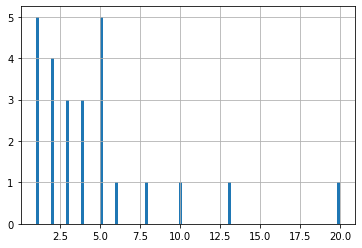

In [15]:
train_df.groupby('user_id').count()['rate'].hist(bins=100)

# indexing data sequentially

In [16]:
users = sorted(train_df.user_id.drop_duplicates().to_list())
items = sorted(train_df.item_id.drop_duplicates().to_list())
print(len(users), len(items))

25 54


In [17]:
users_pivot = pd.DataFrame.from_records([(uid, i) for i, uid in enumerate(users)], columns='user_id user_index'.split())
items_pivot = pd.DataFrame.from_records([(iid, i) for i, iid in enumerate(items)], columns='item_id item_index'.split())
users_pivot.head()

,user_id,user_index
0,4601.0,0
1,13640.0,1
2,17221.0,2
3,17566.0,3
4,25622.0,4


In [18]:
train_df = pd.merge(train_df, users_pivot, on='user_id')
train_df = pd.merge(train_df, items_pivot, on='item_id') 
train_df.head()

,user_id,item_id,rate,timestamp,user_index,item_index
0,69106.0,234465.0,100.0,1.364316e+09,10,41
1,17566.0,234465.0,100.0,1.363942e+09,3,41
2,127118.0,234465.0,-0.0,1.363789e+09,18,41
3,89451.0,229025.0,-0.0,1.364220e+09,14,31
4,4601.0,229025.0,-0.0,1.363637e+09,0,31


In [19]:
indexed_df = train_df.drop('user_id item_id'.split(), axis=1)
indexed_df.head()

,rate,timestamp,user_index,item_index
0,100.0,1.364316e+09,10,41
1,100.0,1.363942e+09,3,41
2,-0.0,1.363789e+09,18,41
3,-0.0,1.364220e+09,14,31
4,-0.0,1.363637e+09,0,31


In [20]:
users = indexed_df.user_index.to_list()
items = indexed_df.item_index.to_list()
rate  = indexed_df.rate.to_list()

shape = (len(set(users)), len(set(items)))
ui_mat = csr_matrix((rate, (users, items)), shape=shape)

In [21]:
ui_mat.shape

(25, 54)

In [22]:
# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=10, calculate_training_loss=True, iterations=20)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(ui_mat)

  0%|          | 0/20 [00:00<?, ?it/s]

# Calc metrics

In [23]:
ui_mat.shape

(25, 54)

In [24]:
recs = []

k = 100
for uid, uix in tqdm(list(users_pivot.to_records(index=False))):
    recs.append(model.recommend(uix, ui_mat, N=k, filter_already_liked_items=False))

  0%|          | 0/25 [00:00<?, ?it/s]

In [25]:
gt = book_test.groupby('user_id')['item_id'].apply(list).tolist()

items_pivot_dict = {rec_id : item_id for item_id, rec_id in list(items_pivot.to_records(index=False))}
# select only items ids and map it to real ids. Without mapping cant calculating metrics with gt dataframe 
rec_items = list(map(lambda rec_list: [items_pivot_dict[x[0]] for x in rec_list], recs))

In [27]:
import numpy as np

def apk(actual, predicted, k=10):    
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

In [28]:
def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [29]:
mapk(gt, rec_items, k=k)

0.013850796357190219